In [55]:
!pip install ultralytics opencv-contrib-python segment-anything cvlib diffusers transformers accelerate torch torchvision opencv-python-headless

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()

KeyboardInterrupt



In [ ]:
import cv2
from cvlib.object_detection import draw_bbox
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to(device)

In [102]:
coco_class_ids = {
    'person': 0,
    'bicycle': 1,
    'car': 2,
    'motorcycle': 3,
    'airplane': 4,
    'bus': 5,
    'train': 6,
    'truck': 7,
    'boat': 8,
    'traffic light': 9,
    'fire hydrant': 10,
    'stop sign': 11,
    'parking meter': 12,
    'bench': 13,
    'bird': 14,
    'cat': 15,
    'dog': 16,
    'horse': 17,
    'sheep': 18,
    'cow': 19,
    'elephant': 20,
    'bear': 21,
    'zebra': 22,
    'giraffe': 23,
    'backpack': 24,
    'umbrella': 25,
    'handbag': 26,
    'tie': 27,
    'suitcase': 28,
    'frisbee': 29,
    'skis': 30,
    'snowboard': 31,
    'sports ball': 32,
    'kite': 33,
    'baseball bat': 34,
    'baseball glove': 35,
    'skateboard': 36,
    'surfboard': 37,
    'tennis racket': 38,
    'bottle': 39,
    'wine glass': 40,
    'cup': 41,
    'fork': 42,
    'knife': 43,
    'spoon': 44,
    'bowl': 45,
    'banana': 46,
    'apple': 47,
    'sandwich': 48,
    'orange': 49,
    'broccoli': 50,
    'carrot': 51,
    'hot dog': 52,
    'pizza': 53,
    'donut': 54,
    'cake': 55,
    'chair': 56,
    'couch': 57,
    'potted plant': 58,
    'bed': 59,
    'dining table': 60,
    'toilet': 61,
    'TV': 62,
    'laptop': 63,
    'mouse': 64,
    'remote': 65,
    'keyboard': 66,
    'cell phone': 67,
    'microwave': 68,
    'oven': 69,
    'toaster': 70,
    'sink': 71,
    'refrigerator': 72,
    'book': 73,
    'clock': 74,
    'vase': 75,
    'scissors': 76,
    'teddy bear': 77,
    'hair drier': 78,
    'toothbrush': 79
}

object_synonyms = {
    'bag': ['handbag', 'backpack', 'suitcase', 'bag'],
    'luggage': ['suitcase', 'backpack', 'luggage'],

    'vehicle': ['car', 'truck', 'bus', 'bicycle', 'motorcycle', 'vehicle'],
    'car': ['car', 'truck', 'bus', 'car'],
    'bike': ['bicycle', 'motorcycle', 'bike'],
    'aircraft': ['airplane', 'aircraft'],
    'ship': ['boat', 'ship'],
    'train': ['train', 'train'],

    'animal': ['dog', 'cat', 'elephant', 'zebra', 'horse', 'bird', 'cow', 'sheep', 'bear', 'giraffe', 'animal'],
    'pet': ['dog', 'cat', 'pet'],
    'wild animal': ['elephant', 'zebra', 'bear', 'giraffe', 'horse', 'wild animal'],
    'bird': ['bird', 'bird'],
    'farm animal': ['cow', 'sheep', 'horse', 'farm animal'],

    'dog': ['dog', 'dog'],
    'cat': ['cat', 'cat'],

    'furniture': ['chair', 'couch', 'bed', 'dining table', 'bench', 'furniture'],
    'table': ['dining table', 'table'],
    'chair': ['chair', 'couch', 'chair'],
    'bed': ['bed', 'bed'],
    'seating': ['chair', 'couch', 'bench', 'seating'],

    'device': ['laptop', 'cell phone', 'mouse', 'keyboard', 'remote', 'device'],
    'computer': ['laptop', 'keyboard', 'mouse', 'computer'],
    'phone': ['cell phone', 'phone'],
    'tv': ['TV', 'tv'],
    'remote': ['remote', 'remote'],

    'kitchen item': ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'kitchen item'],
    'utensil': ['fork', 'knife', 'spoon', 'utensil'],
    'glass': ['wine glass', 'cup', 'glass'],
    'dish': ['bowl', 'dish'],
    'bottle': ['bottle', 'bottle'],

    'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'food'],
    'fruit': ['banana', 'apple', 'orange', 'fruit'],
    'vegetable': ['broccoli', 'carrot', 'vegetable'],
    'dessert': ['donut', 'cake', 'dessert'],
    'fast food': ['hot dog', 'pizza', 'fast food'],

    'clothing': ['tie', 'suitcase', 'clothing'],
    'accessory': ['tie', 'umbrella', 'accessory'],
    'umbrella': ['umbrella', 'umbrella'],

    'sign': ['stop sign', 'traffic light', 'parking meter', 'sign'],
    'light': ['traffic light', 'light'],

    'toy': ['teddy bear', 'toy'],
    'bear': ['teddy bear', 'bear'],

    'clock': ['clock', 'clock'],
    'book': ['book', 'book'],
    'plant': ['potted plant', 'plant'],
    'scissors': ['scissors', 'scissors'],
    'toiletries': ['toothbrush', 'hair drier', 'toiletries'],
    
    'laptop': ['laptop'],
    'handbag': ['handbag'],
    'backpack': ['backpack'],
    'suitcase': ['suitcase'],
    'bicycle': ['bicycle'],
    'motorcycle': ['motorcycle'],
    'airplane': ['airplane'],
    'bus': ['bus'],
    'train': ['train'],
    'truck': ['truck'],
    'boat': ['boat'],
    'traffic light': ['traffic light'],
    'fire hydrant': ['fire hydrant'],
    'stop sign': ['stop sign'],
    'parking meter': ['parking meter'],
    'bench': ['bench'],
    'bird': ['bird'],
    'cat': ['cat'],
    'dog': ['dog'],
    'horse': ['horse'],
    'sheep': ['sheep'],
    'cow': ['cow'],
    'elephant': ['elephant'],
    'bear': ['bear'],
    'zebra': ['zebra'],
    'giraffe': ['giraffe'],
    'frisbee': ['frisbee'],
    'skis': ['skis'],
    'snowboard': ['snowboard'],
    'sports ball': ['sports ball'],
    'kite': ['kite'],
    'baseball bat': ['baseball bat'],
    'baseball glove': ['baseball glove'],
    'skateboard': ['skateboard'],
    'surfboard': ['surfboard'],
    'tennis racket': ['tennis racket'],
    'bottle': ['bottle'],
    'wine glass': ['wine glass'],
    'cup': ['cup'],
    'fork': ['fork'],
    'knife': ['knife'],
    'spoon': ['spoon'],
    'bowl': ['bowl'],
    'banana': ['banana'],
    'apple': ['apple'],
    'sandwich': ['sandwich'],
    'orange': ['orange'],
    'broccoli': ['broccoli'],
    'carrot': ['carrot'],
    'hot dog': ['hot dog'],
    'pizza': ['pizza'],
    'donut': ['donut'],
    'cake': ['cake'],
    'chair': ['chair'],
    'couch': ['couch'],
    'potted plant': ['potted plant'],
    'bed': ['bed'],
    'dining table': ['dining table'],
    'toilet': ['toilet'],
    'TV': ['TV'],
    'mouse': ['mouse'],
    'remote': ['remote'],
    'keyboard': ['keyboard'],
    'cell phone': ['cell phone'],
    'microwave': ['microwave'],
    'oven': ['oven'],
    'toaster': ['toaster'],
    'sink': ['sink'],
    'refrigerator': ['refrigerator'],
    'book': ['book'],
    'clock': ['clock'],
    'vase': ['vase'],
    'scissors': ['scissors'],
    'teddy bear': ['teddy bear'],
    'hair drier': ['hair drier'],
    'toothbrush': ['toothbrush'],
}

In [ ]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import numpy as np

model_type = "vit_h"
sam_checkpoint = "/kaggle/input/avataar/Avataar/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [104]:
img_choice = input("Enter the image path: ")
#SAMPLE IMAGES WITH PATH (KAGGLE):
#BAGPACK: /kaggle/input/avataar/bagpack.jpg
#WALL-HANGING: /kaggle/input/avataar/wall hanging.jpg 

Enter the image path:  /kaggle/input/avataar/bagpack.jpg


In [105]:
def get_class_ids(user_term):
    specific_classes = object_synonyms.get(user_term.lower())
    
    if specific_classes:
        class_ids = []
        for class_name in specific_classes:
            class_id = coco_class_ids.get(class_name)
            if class_id is not None:
                class_ids.append(class_id)
        return class_ids
    else:
        class_ids = []
        print(f"No synonyms found for '{user_term}'.")
        return []



In [106]:
obj = input("What do you want to move?: ")

What do you want to move?:  laptop


In [107]:
possible_classes = get_class_ids(obj)

if possible_classes:
    print(f"Class IDs for '{obj}': {possible_classes}")
else:
    print(f"'{obj}' is not found in the object synonyms.")

Class IDs for 'laptop': [63]


In [108]:
def outpaint(img_choice,obj):
    
    
    
    image = Image.open(img_choice)
    
    image_width, image_height = image.size
    outpaint_width = 100
    outpaint_height = 100


    extended_image = Image.new("RGB", (image_width + 2 * outpaint_width, image_height + 2 * outpaint_height), (255, 255, 255))
    extended_image.paste(image, (outpaint_width, outpaint_height))

    mask = Image.new("L", (image_width + 2 * outpaint_width, image_height + 2 * outpaint_height), 255)
    mask.paste(0, (outpaint_width, outpaint_height, outpaint_width + image_width, outpaint_height + image_height))



    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Extended Image")
    plt.imshow(extended_image)

    plt.subplot(1,2,2)
    plt.title("Mask for Outpainting")
    plt.imshow(mask, cmap='gray')

    plt.show()


    prompt = f"Complete the {obj} in high detail"
    neg_prompt = "Add any new objects"

    outpainted_image = pipe(prompt=prompt,negative_prompt = neg_prompt,num_inference_steps=50,guidance_scale = 10, image=extended_image, mask_image=mask, height = 16*round((image_height+200)/16), width = 16*round((image_width+200)/16)).images[0]
    
    outpainted_image.save("outpainted_img.jpg")

    plt.imshow(outpainted_image)
    return ("outpainted_img.jpg")

In [109]:
def find_obj(img_choice, possible_classes, obj, already_extended):
    img = cv2.imread(img_choice)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)

    detected_class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.4 and class_id in possible_classes:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                detected_class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    
    if boxes == []:
        return img_choice, -1, -1, -1, -1
    
    def draw_bbox(img, boxes, detected_class_ids, confidences, indices):
        indices = indices.flatten() if isinstance(indices, np.ndarray) else indices

        max_area = 0
        best_box = None
        best_index = None

        # Find the box with the highest area
        for i in indices:
            if i < len(boxes):
                box = boxes[i]
                (x, y, w, h) = box
                area = w * h
                if area > max_area:
                    max_area = area
                    best_box = box
                    best_index = i

        if best_box:
            x, y, w, h = best_box
            label = f"{obj}: {confidences[best_index]:.2f}"
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        return img, x, y, w, h

    print(f"Boxes length: {len(boxes)}, Detected Class IDs length: {len(detected_class_ids)}, "
          f"Confidences length: {len(confidences)}, Indices length: {len(indices)}")

    print("boxes", boxes)

    output_image, x, y, w, h = draw_bbox(img, boxes, detected_class_ids, confidences, indices)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    plt.imshow(output_image)


    if ((x < 5 or y < 5 or (x + w) > width - 5 or (y + h) > height - 5) and already_extended == 0):
        print("Object found on edge, outpainting to get full object")
        img_choice = outpaint(img_choice, obj)
        already_extended = 1
        return find_obj(img_choice, possible_classes, obj, already_extended)
    cv2.imwrite("output.jpg", output_image)
    return img_choice, x, y, w, h, already_extended

Boxes length: 4, Detected Class IDs length: 4, Confidences length: 4, Indices length: 1
boxes [[212, 146, 190, 111], [219, 149, 203, 108], [218, 153, 183, 107], [219, 152, 210, 112]]


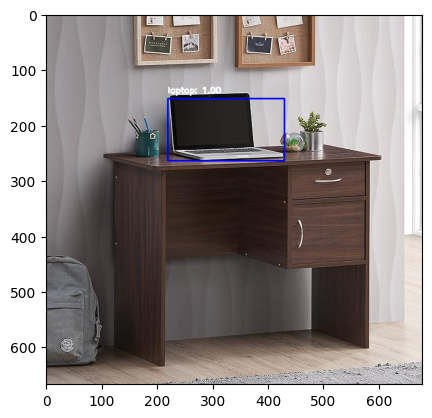

In [110]:
import cv2
import numpy as np
weights = "/kaggle/input/avataar/Avataar/yolov3.weights"
config = "/kaggle/input/avataar/Avataar/yolov3.cfg"
net = cv2.dnn.readNet(weights, config)
extended = 0
res,x,y,w,h,extended = find_obj(img_choice, possible_classes, obj, extended)
if x == -1 and  y == -1 and w == -1 and h == -1:
    print("Object not found in the image")
else:
    if extended == 1:
        img_choice = f"/kaggle/working/{res}"

In [111]:
print(img_choice)

/kaggle/input/avataar/bagpack.jpg


In [112]:
print(x,y,w,h)

219 152 210 112


In [114]:
image = cv2.imread(img_choice)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image_rgb)


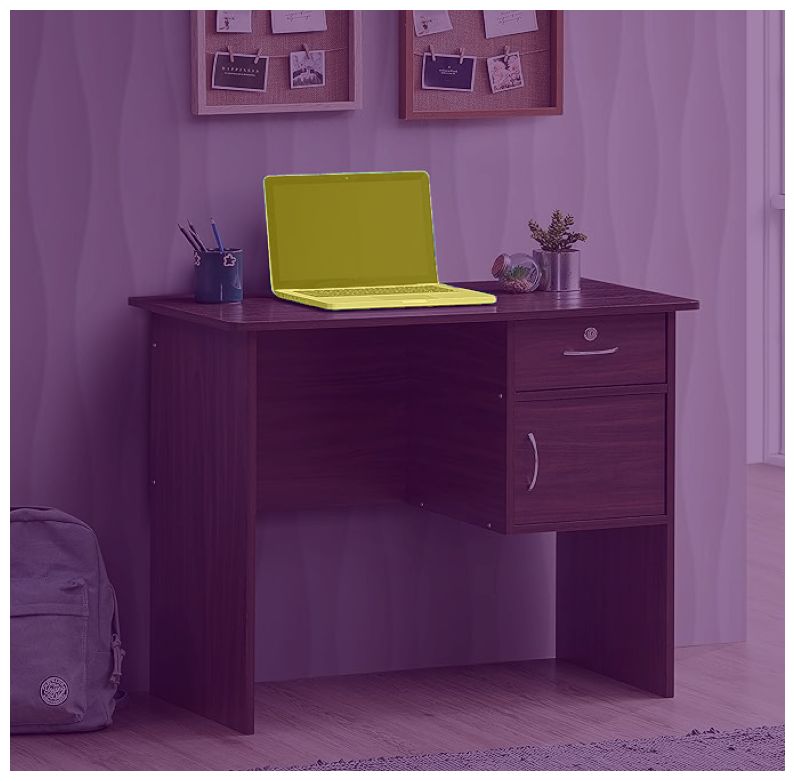

In [115]:
padding = 25

# x,y = 17,531
# w,h = 188,202

input_box = np.array([x-padding,y-padding,x+w+padding,y+h+padding])

input_box = torch.tensor(input_box).unsqueeze(0).numpy()

masks, _, _ = predictor.predict(box=input_box)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

for mask in masks:
    plt.imshow(mask, alpha=0.2)

plt.axis('off')
plt.show()

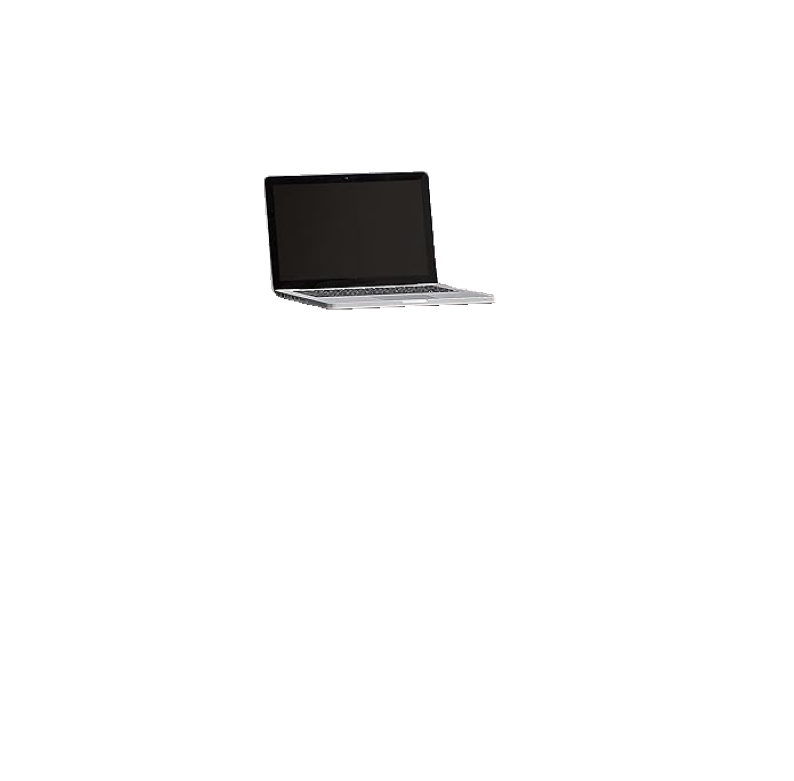

True

In [116]:
mask = masks[0]

height, width, _ = image_rgb.shape
subject_image_rgba = np.zeros((height, width, 4), dtype=np.uint8)

subject_image_rgba[..., :3] = np.where(mask[..., np.newaxis], image_rgb, 0)

subject_image_rgba[..., 3] = np.where(mask, 255, 0)

plt.figure(figsize=(10, 10))
plt.imshow(subject_image_rgba)
plt.axis('off')
plt.show()

cv2.imwrite("subject.png", cv2.cvtColor(subject_image_rgba, cv2.COLOR_RGBA2BGRA))

In [117]:

def cv2_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def pil_to_cv2(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

(667, 679)


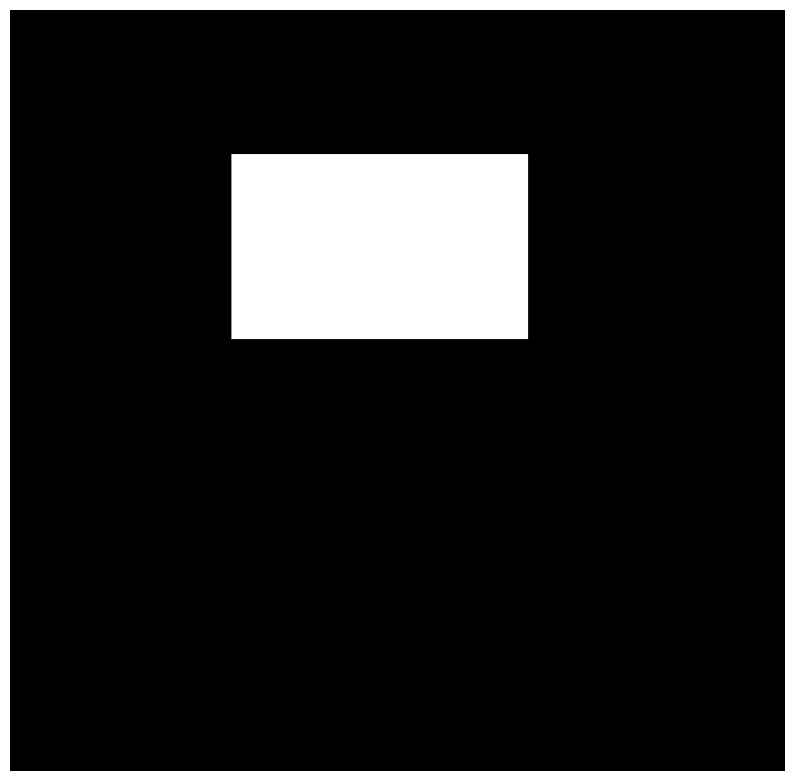

In [118]:
rect_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)
print(rect_mask.shape)
y0 = max(0,y-padding)
x0 = max(0, x-padding)
y1 = min((rect_mask.shape)[0],y+h+padding)
x1 = min((rect_mask.shape)[1],x+w+padding)
rect_mask[y0:y1, x0:x1] = 255

mask_pil = Image.fromarray(rect_mask)

plt.figure(figsize=(10, 10))
plt.imshow(mask_pil, cmap="gray")
plt.axis('off')
plt.show()


In [119]:
image_pil = Image.fromarray(image_rgb)

In [120]:
image_width = (image_pil.size)[0]
image_height = (image_pil.size)[1]
print(image_height, image_width)
aspect = image_width/image_height
print(16*round(image_height/16))

667 679
672


  0%|          | 0/50 [00:00<?, ?it/s]

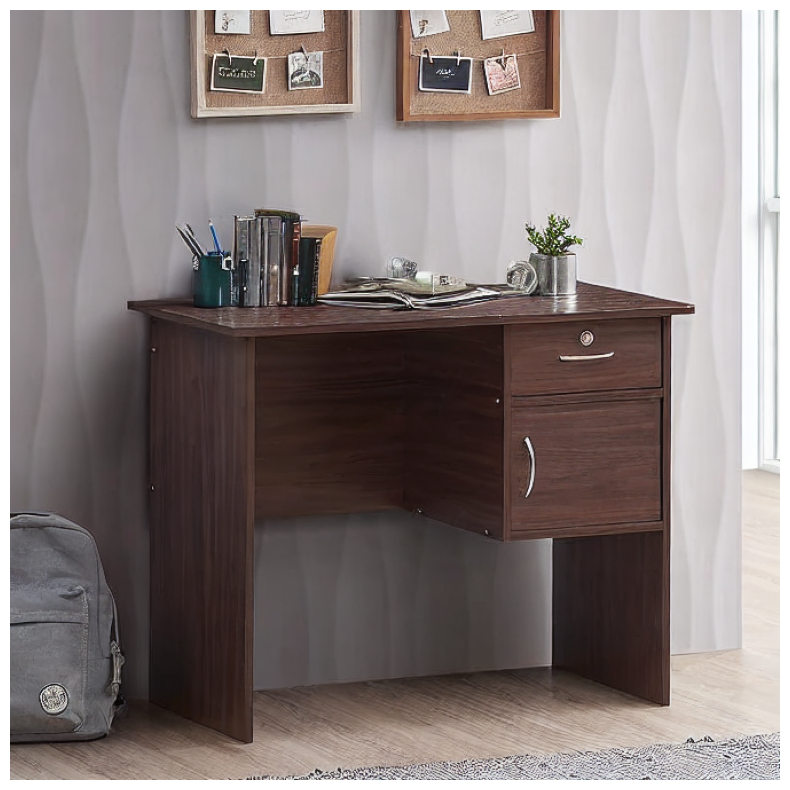

In [122]:
from matplotlib import pyplot as plt
prompt = "Complete the scene by blending in with the background."
negative_prompt = "No objects, no characters, no distinct elements, only blend into the background."

inpainted_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image_pil,
    mask_image=mask_pil,
    num_inference_steps=50,
    guidance_scale=10,
    height = 16*round(image_height/16),
    width = 16*round(image_width/16)

).images[0]

plt.figure(figsize=(10, 10))
plt.imshow(inpainted_image)
plt.axis('off')
plt.show()

inpainted_image.save("final_inpainted_image.jpg")

In [129]:
h_change = int(input(f"How many pixels down do you want the {obj} (enter negative number for up)"))
w_change = int(input(f"How many pixels right do you want the {obj} (enter negative number for left)"))

How many pixels down do you want the laptop (enter negative number for up) 300
How many pixels right do you want the laptop (enter negative number for left) 0


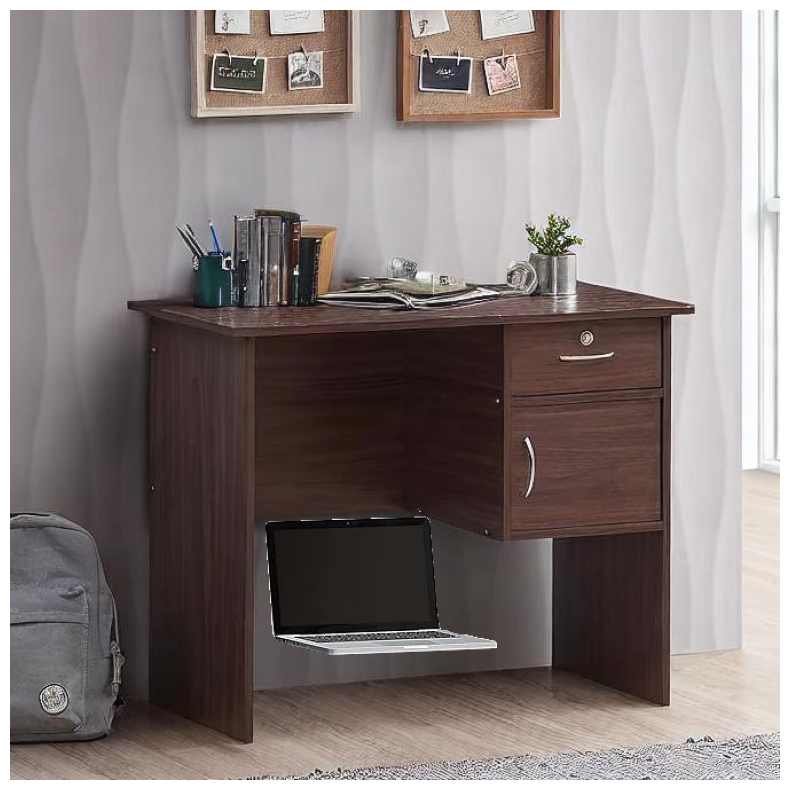

In [130]:
from PIL import Image

final_inpainted_image = Image.open("/kaggle/working/final_inpainted_image.jpg")

subject_image = Image.open("/kaggle/working/subject.png")

final_image = final_inpainted_image.copy()
final_image.paste(subject_image, (w_change, h_change), subject_image)

plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.show()

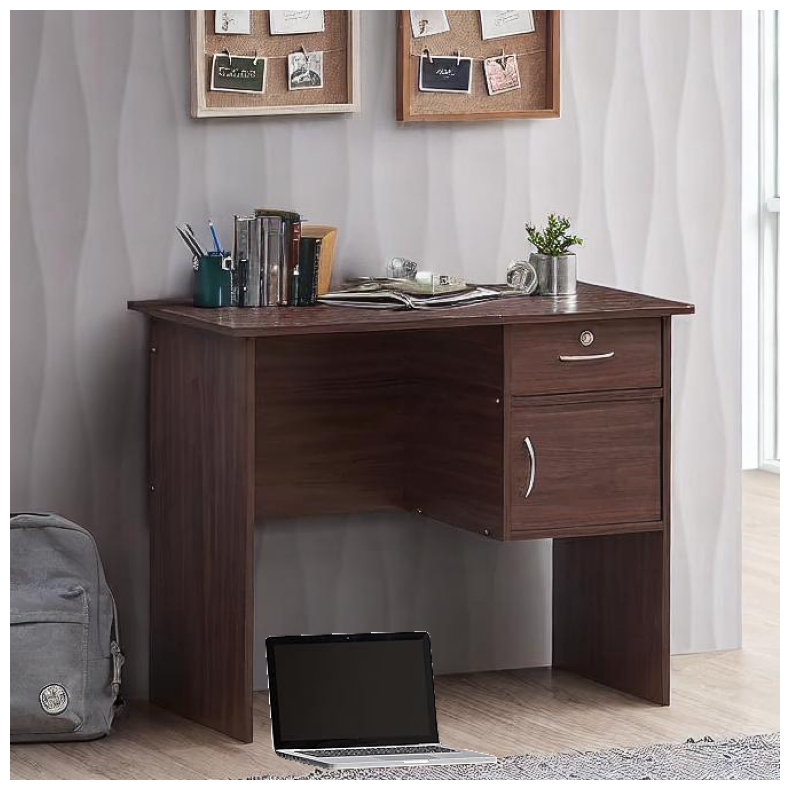

In [128]:
if extended == 1:
    final_image = final_image.crop((100,100,(width-100),(height-100)))
final_image.save("final_image_with_subject.png")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.show()